In [1]:
%load_ext autoreload
%autoreload 2

import os
import json

import numpy as np
import pandas as pd
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation

pd.set_option('display.width', 250)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)

%matplotlib inline
mpl.rcParams['animation.embed_limit'] = 100

root_path = os.path.abspath("..")
import sys
sys.path.append(root_path)
from config import TEAM_NAME

In [2]:
raw_data_path = "/data/MHL/bepro/raw"
processed_data_path = "/data/MHL/bepro/processed"
match_ids = os.listdir(raw_data_path)
os.listdir(os.path.join(raw_data_path, match_ids[0]))

['153390_2_event_data.json',
 '153390_1_frame_data.jsonl',
 '153390_1_event_data.json',
 '153390_2_frame_data.jsonl',
 '153390_metadata.json']

In [5]:
error_ids = ["126319", "153381", "153390", "126285"]

for i, match_id in enumerate(match_ids):
    if match_id in error_ids: continue
    metadata_path = f"{raw_data_path}/{match_id}/{match_id}_metadata.json"
    with open(metadata_path) as f:
        metadata = json.load(f)
        home_team =TEAM_NAME[metadata["home_team"]["team_name"]]
        away_team =TEAM_NAME[metadata["away_team"]["team_name"]]
        print(f"[{metadata['match_datetime'][:10]}] {match_id}: {home_team} vs {away_team}")

[2024-03-10] 126293: Gwangju FC vs Gangwon FC
[2024-03-17] 126298: Pohang Steelers vs Gwangju FC
[2024-03-31] 126306: Gwangju FC vs Daegu FC
[2024-04-03] 126309: Gwangju FC vs Incheon United
[2024-04-06] 126315: Gimcheon Sangmu vs Gwangju FC
[2024-05-15] 126325: Gwangju FC vs Ulsan HD FC
[2024-04-27] 126332: Gwangju FC vs Suwon FC
[2024-05-01] 126341: Jeju SK FC vs Gwangju FC
[2024-05-06] 126348: Gwangju FC vs Daejeon Hana Citizen
[2024-05-11] 126350: Daegu FC vs Gwangju FC
[2024-05-19] 126356: Gwangju FC vs Jeonbuk Hyundai Motors
[2024-05-25] 126364: Incheon United vs Gwangju FC
[2024-05-28] 126367: Gwangju FC vs Pohang Steelers
[2024-06-02] 126378: FC Seoul vs Gwangju FC
[2024-06-15] 126380: Gwangju FC vs Gimcheon Sangmu
[2024-06-22] 126386: Daejeon Hana Citizen vs Gwangju FC
[2024-06-25] 126391: Suwon FC vs Gwangju FC
[2024-06-30] 126401: Gwangju FC vs Jeju SK FC
[2024-07-07] 126408: Gangwon FC vs Gwangju FC
[2024-07-10] 126411: Ulsan HD FC vs Gwangju FC
[2024-07-14] 126418: Gwangju

In [8]:
match_path = f"{raw_data_path}/{match_id}"
os.listdir(match_path)

['153390_metadata.json',
 '153390_2_event_data.json',
 '153390_2_frame_data.jsonl',
 '153390_1_frame_data.jsonl',
 '153390_1_event_data.json']

In [10]:
match_id = "126285"
match_path = f"{processed_data_path}/{match_id}"

with open(f"{match_path}/{match_id}_processed_dict.pkl", "rb") as f:
    match_dict = pickle.load(f)

match_dict.keys()

dict_keys(['tracking_df', 'event_df', 'teams', 'meta_data'])

In [11]:
tracking_df = match_dict['tracking_df']
event_df = match_dict['event_df']
teams_dict = match_dict['teams']
meta_data = match_dict['meta_data']

In [12]:
event_df["period_order"] = event_df['period_order'] + 1
event_df["event_time"] = event_df["event_time"] / 1000
event_df['event_time'] = (event_df['event_time'] / 0.04).round() * 0.04
event_df['event_time'] = pd.to_timedelta(event_df['event_time'], unit='s')
event_df.rename(columns={
    'period_order' : 'period_id',
    'event_time' : 'timestamp'},
    inplace=True)
event_df['timestamp']

0      0 days 00:00:01.520000
1      0 days 00:00:02.320000
2      0 days 00:00:03.120000
3      0 days 00:00:04.120000
4      0 days 00:00:05.320000
                ...          
2018   0 days 01:37:49.240000
2019   0 days 01:37:49.680000
2020   0 days 01:37:49.720000
2021   0 days 01:37:53.440000
2022   0 days 01:37:53.600000
Name: timestamp, Length: 3918, dtype: timedelta64[ns]

In [13]:
teams_df = pd.concat([teams_dict['Home'], teams_dict['Away']])
teams_df.reset_index(drop=True, inplace=True)
teams_df['player_code'] = teams_df.apply(lambda row : row['team'][0] + str(row['xID']).zfill(2), axis=1)
teams_df.head()

,player,position,team,jID,pID,tID,xID,player_code
0,Kyeongmin Kim,GK,Home,1,250079,4648,0,H00
1,Alexandar Popovic,CB,Home,4,500133,4648,1,H01
2,Youngkyu Ahn,CB,Home,6,62365,4648,2,H02
3,Hyeonseok Doo,RB,Home,13,62386,4648,3,H03
4,Jinho Kim,LB,Home,27,500140,4648,4,H04


In [14]:
event_df = event_df.merge(
    teams_df,
    how='left',
    left_on=['player_name', 'player_shirt_number'],
    right_on=['player', 'jID']
)

events = event_df.drop(['player', 'team', 'jID'], axis=1)
events["pID"] = events["pID"].astype(int)
events.head()

,period_type,period_name,period_id,period_duration,period_start_time,timestamp,team_name,player_shirt_number,player_name,events,x,y,to_x,to_y,attack_direction,position,pID,tID,xID,player_code
0,Half,1st Half,1,2700000,0,0 days 00:00:01.520000,Gwangju FC,20,Kunhee Lee,"[{'event_name': 'Passes', 'property': {'Outcom...",0.5010,0.5060,0.4276,0.6138,RIGHT,CF,250102,4648,10,H10
1,Half,1st Half,1,2700000,0,0 days 00:00:02.320000,Gwangju FC,10,Huigyun Lee,"[{'event_name': 'Passes Received', 'property':...",0.4276,0.6138,NaN,NaN,RIGHT,CF,77414,4648,9,H09
2,Half,1st Half,1,2700000,0,0 days 00:00:03.120000,Gwangju FC,10,Huigyun Lee,"[{'event_name': 'Passes', 'property': {'Outcom...",0.4230,0.6042,0.3712,0.5116,RIGHT,CF,77414,4648,9,H09
3,Half,1st Half,1,2700000,0,0 days 00:00:04.120000,Gwangju FC,14,Hoyeon Jeong,"[{'event_name': 'Passes Received', 'property':...",0.3712,0.5116,NaN,NaN,RIGHT,CM,250101,4648,6,H06
4,Half,1st Half,1,2700000,0,0 days 00:00:05.320000,Gwangju FC,14,Hoyeon Jeong,"[{'event_name': 'Passes', 'property': {'Outcom...",0.3659,0.4809,0.2850,0.4001,RIGHT,CM,250101,4648,6,H06


In [24]:
event_df[event_df['x'] == event_df['x'].min()]

,period_type,period_name,period_id,period_duration,period_start_time,timestamp,team_name,player_shirt_number,player_name,events,x,y,to_x,to_y,attack_direction,player,position,team,jID,pID,tID,xID,player_code
547,Half,1st Half,1,2700000,0,0 days 00:13:15.800000,FC Seoul,6,Sungyueng Ki,"[{'event_name': 'Set Pieces', 'property': {'Ty...",0.0,1.0000,0.0870,0.4189,LEFT,Sungyueng Ki,CM,Away,6,161110,316,5,A05
1829,Half,1st Half,1,2700000,0,0 days 00:46:56,FC Seoul,26,Aleksandar Palocevic,"[{'event_name': 'Set Pieces', 'property': {'Ty...",0.0,1.0000,0.0497,0.5621,LEFT,Aleksandar Palocevic,CAM,Away,26,187326,316,7,A07
1832,Half,1st Half,1,2700000,0,0 days 00:47:17.520000,FC Seoul,26,Aleksandar Palocevic,"[{'event_name': 'Set Pieces', 'property': {'Ty...",0.0,1.0000,0.0404,0.6370,LEFT,Aleksandar Palocevic,CAM,Away,26,187326,316,7,A07
2718,Half,2nd Half,2,2700000,2700000,0 days 01:02:08.080000,Gwangju FC,10,Huigyun Lee,"[{'event_name': 'Passes', 'property': {'Outcom...",0.0,0.7145,0.0043,0.7913,LEFT,Huigyun Lee,CF,Home,10,77414,4648,9,H09
3871,Half,2nd Half,2,2700000,2700000,0 days 01:36:23.200000,FC Seoul,21,Chul Won Choi,"[{'event_name': 'Goals Conceded', 'property': ...",0.0,0.5366,NaN,NaN,RIGHT,Chul Won Choi,GK,Away,21,344466,316,0,A00


In [15]:
tracking_df = tracking_df.merge(
    teams_df[['pID', 'player_code']],
    how='left',
    left_on = 'id',
    right_on = 'pID'
)
tracking_df.drop(['pID'], axis=1, inplace=True)

# Ball id
nan_mask = pd.isna(tracking_df['player_code'])
tracking_df.loc[nan_mask, 'player_code'] = tracking_df.loc[nan_mask, 'id']
tracking_df[pd.isna(tracking_df['player_code'])]

,game_id,period_id,timestamp,frame_id,ball_state,ori_ball_owning_team_id,x,y,z,vx,vy,vz,v,ax,ay,az,a,id,team_id,position_name,ball_owning_team_id,is_ball_carrier,player_code


In [16]:
wide_tracking_df = tracking_df.pivot_table(
    index= ['period_id', 'timestamp'],
    columns='player_code',
    values=['x', 'y', 'vx', 'vy', 'v', 'ax', 'ay', 'a']
)

wide_tracking_df.columns = [f'{player_code}_{value}' for value, player_code in wide_tracking_df.columns]
wide_tracking_df.reset_index(inplace=True)
wide_tracking_df.head()

,period_id,timestamp,A00_a,A01_a,A02_a,A03_a,A04_a,A05_a,A06_a,A07_a,A08_a,A09_a,A10_a,A12_a,A16_a,...,H02_y,H03_y,H04_y,H05_y,H06_y,H07_y,H08_y,H09_y,H10_y,H13_y,H14_y,H17_y,H18_y,H19_y,ball_y
0,1.0,0 days 00:00:01.600000,0.833636,0.801928,0.438798,1.136679,0.386234,0.783309,0.168454,0.250580,1.802438,1.207012,0.358486,NaN,NaN,...,-2.359300,-13.559400,17.767500,-24.221900,-0.352700,20.775700,-9.819000,8.185700,0.460700,NaN,NaN,NaN,NaN,NaN,1.287600
1,1.0,0 days 00:00:01.640000,0.912114,0.712823,0.654844,1.288636,0.257367,1.130015,0.352727,0.187580,2.047910,1.409507,0.478127,NaN,NaN,...,-2.386343,-13.579853,17.804729,-24.242417,-0.341155,20.784122,-9.818962,8.196821,0.467138,NaN,NaN,NaN,NaN,NaN,1.643693
2,1.0,0 days 00:00:01.680000,0.877232,0.929945,0.627449,1.170392,0.279887,1.079380,0.389130,0.265076,1.830899,1.494646,0.434642,NaN,NaN,...,-2.411216,-13.600553,17.842348,-24.261414,-0.330829,20.794340,-9.817375,8.207223,0.472168,NaN,NaN,NaN,NaN,NaN,1.995108
3,1.0,0 days 00:00:01.720000,0.936028,0.867308,0.745298,1.304597,0.335371,1.312517,0.398230,0.411878,1.845123,1.728930,0.627545,NaN,NaN,...,-2.433740,-13.621799,17.880450,-24.279072,-0.321164,20.806506,-9.813286,8.216870,0.475780,NaN,NaN,NaN,NaN,NaN,2.344248
4,1.0,0 days 00:00:01.760000,1.009509,0.754464,0.795397,1.506144,0.430078,1.571081,0.483762,0.608332,1.822465,1.907611,0.785753,NaN,NaN,...,-2.454691,-13.644408,17.920185,-24.296003,-0.311434,20.820994,-9.808059,8.225870,0.478581,NaN,NaN,NaN,NaN,NaN,2.701439


In [17]:
traces_df = events.merge(
    wide_tracking_df,
    on = ['period_id', 'timestamp'],
    how='left',
)

traces_df.head()

,period_type,period_name,period_id,period_duration,period_start_time,timestamp,team_name,player_shirt_number,player_name,events,x,y,to_x,to_y,attack_direction,...,H02_y,H03_y,H04_y,H05_y,H06_y,H07_y,H08_y,H09_y,H10_y,H13_y,H14_y,H17_y,H18_y,H19_y,ball_y
0,Half,1st Half,1,2700000,0,0 days 00:00:01.520000,Gwangju FC,20,Kunhee Lee,"[{'event_name': 'Passes', 'property': {'Outcom...",0.5010,0.5060,0.4276,0.6138,RIGHT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Half,1st Half,1,2700000,0,0 days 00:00:02.320000,Gwangju FC,10,Huigyun Lee,"[{'event_name': 'Passes Received', 'property':...",0.4276,0.6138,NaN,NaN,RIGHT,...,-2.665404,-14.070208,18.489904,-24.450229,-0.029094,21.396272,-9.720615,8.150656,0.434475,NaN,NaN,NaN,NaN,NaN,7.650964
2,Half,1st Half,1,2700000,0,0 days 00:00:03.120000,Gwangju FC,10,Huigyun Lee,"[{'event_name': 'Passes', 'property': {'Outcom...",0.4230,0.6042,0.3712,0.5116,RIGHT,...,-3.230050,-14.703333,19.362398,-24.717457,0.505598,22.872502,-9.770779,7.670264,0.224072,NaN,NaN,NaN,NaN,NaN,6.973636
3,Half,1st Half,1,2700000,0,0 days 00:00:04.120000,Gwangju FC,14,Hoyeon Jeong,"[{'event_name': 'Passes Received', 'property':...",0.3712,0.5116,NaN,NaN,RIGHT,...,-4.142699,-15.583341,20.407601,-25.926814,0.881246,25.129370,-9.909187,7.149643,0.153217,NaN,NaN,NaN,NaN,NaN,0.859861
4,Half,1st Half,1,2700000,0,0 days 00:00:05.320000,Gwangju FC,14,Hoyeon Jeong,"[{'event_name': 'Passes', 'property': {'Outcom...",0.3659,0.4809,0.2850,0.4001,RIGHT,...,-5.455038,-16.707880,21.987749,-27.708540,-0.266786,27.855634,-10.644120,7.271518,0.042228,NaN,NaN,NaN,NaN,NaN,-1.266984


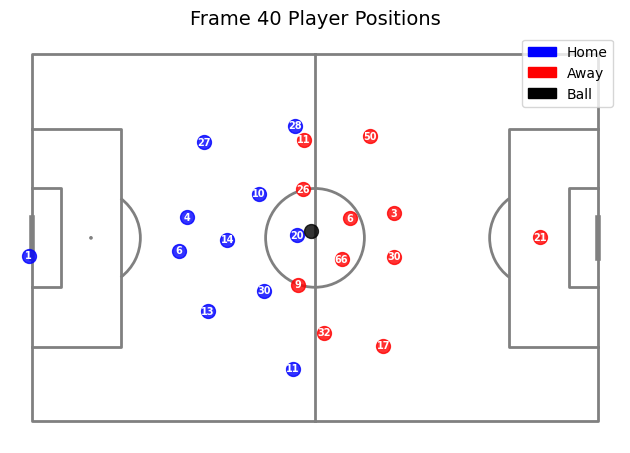

In [18]:
# Visualization

from visualization import plot_single_frame_positions, plot_window_frame_positions

frame_id = tracking_df[tracking_df['period_id']==1]['frame_id'].iloc[0]
plot_single_frame_positions(tracking_df, period_id=1, frame_idx=frame_id, home_team_info=teams_dict['Home'], away_team_info=teams_dict['Away'])

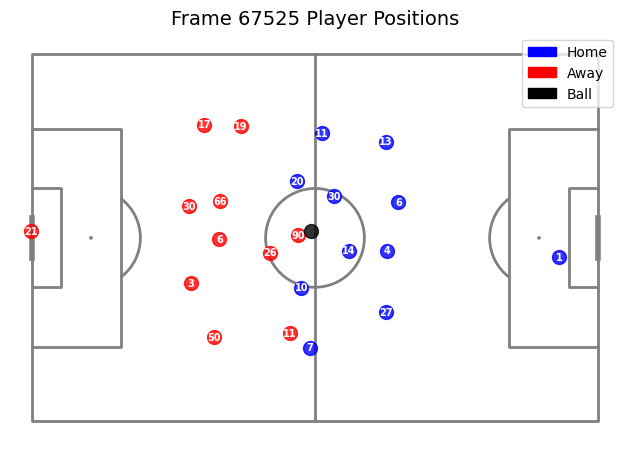

In [28]:
# Visualization

from visualization import plot_single_frame_positions, plot_window_frame_positions

frame_id = tracking_df[tracking_df['period_id']==2]['frame_id'].iloc[0]
plot_single_frame_positions(tracking_df, period_id=2, frame_idx=frame_id, home_team_info=teams_dict['Home'], away_team_info=teams_dict['Away'])

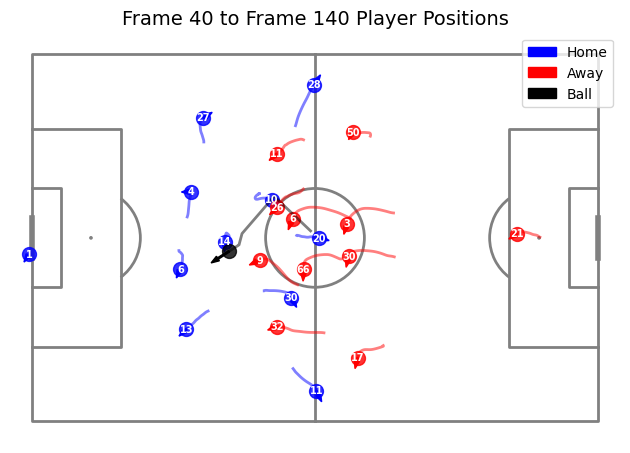

In [19]:
plot_window_frame_positions(tracking_df, period_id=1, start_frame_idx=frame_id, end_frame_idx = frame_id+100, home_team_info=teams_dict['Home'], away_team_info=teams_dict['Away'])